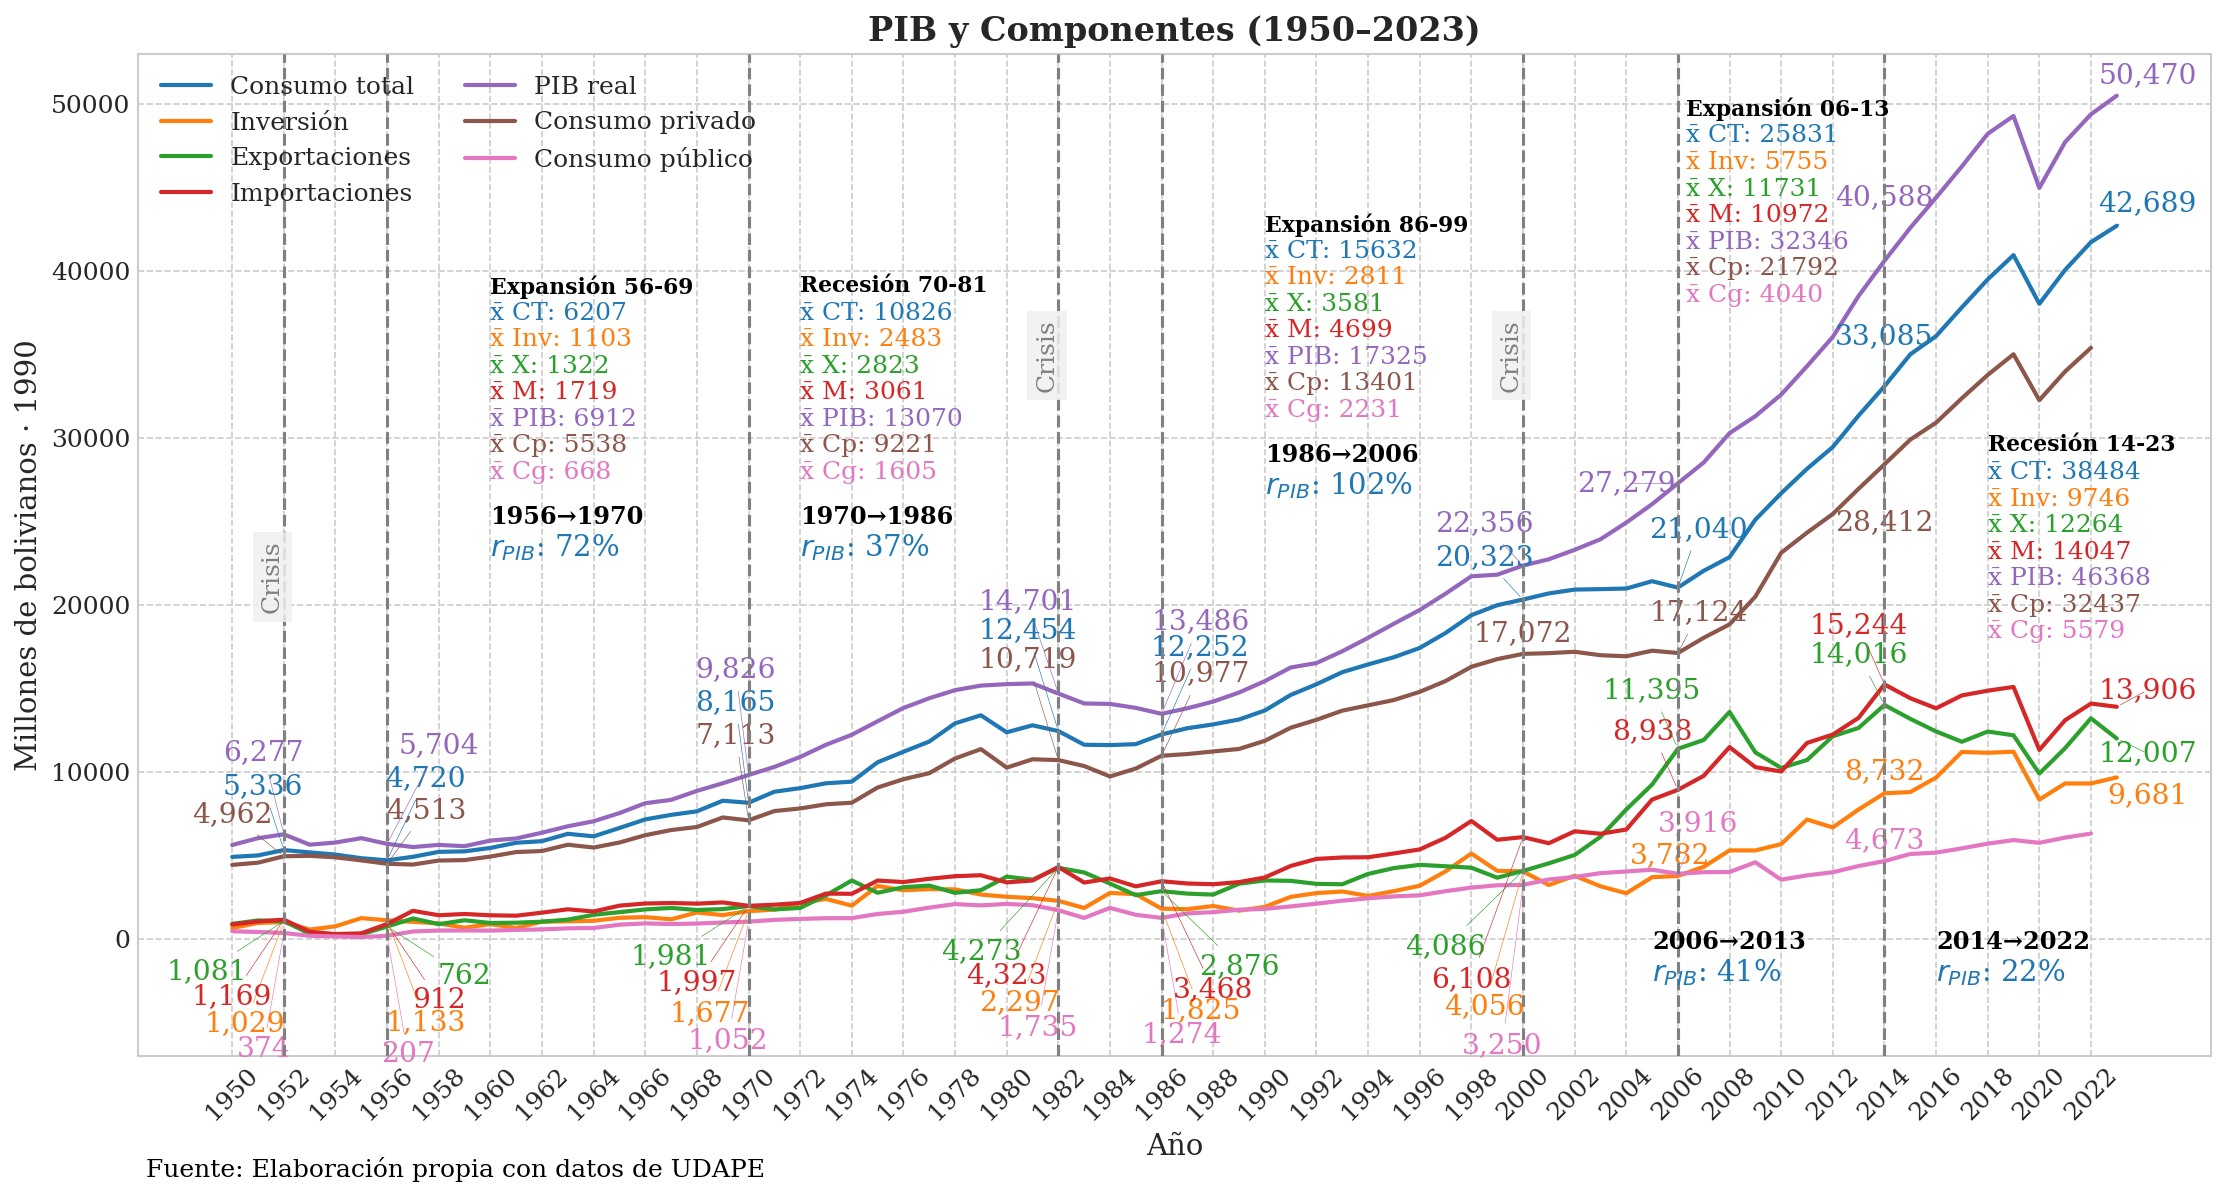

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
import sys
sys.path.append(os.path.abspath('../'))          # utilidades propias
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi,
    add_participation_cycle_boxes
)

CRISIS_52_55      = slice(1952, 1955)   # Crisis
EXPANSION_56_69   = slice(1956, 1969)   # Expansión
RECESION_70_81    = slice(1970, 1981)   # Recesión
CRISIS_82_85      = slice(1982, 1985)   # Crisis (neoliberal)
EXPANSION_86_99   = slice(1986, 1999)   # Expansión
CRISIS_00_05      = slice(2000, 2005)   # Crisis
ACUMULACION_06_13 = slice(2006, 2013)   # Acumulación (expansión)
RECESION_14_23    = slice(2014, 2024)   # Recesión

# ── 1. Configuración general y salida ────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif','font.size':12,
    'axes.titlesize':16,'axes.labelsize':14,
    'grid.linestyle':'--','lines.linewidth':2,
    'figure.dpi':150,'savefig.bbox':'tight'
})
component_colors = {
    'pib_real_base_1990': '#1f77b4'
}
# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = pd.read_sql("SELECT * FROM pib_real_gasto", conn, index_col='año') / 1000

# ── 3. Componentes y estadísticas ───────────────────────────────────
componentes = [
    ("gastos_consumo",               "Consumo total"),
    ("formacion_capital",            "Inversión"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes",           "Importaciones"),
    ("pib_real_base_1990",           "PIB real"),
    ("consumo_privado",              "Consumo privado"),
    ("consumo_publico",              "Consumo público"),
]

def cuadro_stats(sub, a, b):
    lines = []
    for col,label in componentes:
        μ    = sub[col].mean()
        Δpct = (df.loc[b,col] - df.loc[a,col]) / df.loc[a,col] * 100
        lines.append(f"{label}: μ={μ:,.0f}  Δ{b}/{a}={Δpct:.1f}%")
    return "\n".join(lines)

def calcular_tasa_de_crecimiento(df,valor_final,valor_inicial,columna):
    return int(((df.loc[valor_final, columna]/df.loc[valor_inicial, columna]-1)*100).round(0))

txt_cr = "Crisis 52-56\n" + cuadro_stats(df.loc[1952:1956], 1952, 1956)
txt_po = "Post-crisis 56-82\n" + cuadro_stats(df.loc[1956:1982], 1956, 1982)
#estadisticas
avg_expansion_56_69   = df.loc[EXPANSION_56_69].mean()
avg_recesion_70_81    = df.loc[RECESION_70_81].mean()
avg_expansion_86_99   = df.loc[EXPANSION_86_99].mean()
avg_expansion_06_13 = df.loc[ACUMULACION_06_13].mean()
avg_recesion_14_23    = df.loc[RECESION_14_23].mean()

tasa_1970_1956 = calcular_tasa_de_crecimiento(df, 1970, 1956, 'pib_real_base_1990')
tasa_1986_1970 = calcular_tasa_de_crecimiento(df, 1986, 1970, 'pib_real_base_1990')
tasa_2006_1986 = calcular_tasa_de_crecimiento(df, 2006, 1986, 'pib_real_base_1990')
tasa_2014_2006 = calcular_tasa_de_crecimiento(df, 2014, 2006, 'pib_real_base_1990')


# ── 4. Configuración de hitos y anotaciones ────────────────────────
# Años donde dibujaremos líneas verticales
hitos_v = {
    1952: "Crisis",
    1956: "Expansión",
    1970: "Recesión",
    1982: "Crisis",
    1986: "Expansión",
    2000: "Crisis",
    2006: "Expansión",
    2014: "Recesión"
}

# Años que queremos anotar en todas las series
anot_years = [1952,1956,1970,1982, 1986, 2000, 2006,2014, 2023]

# ── Offsets personalizados para cada componente y año ──────────────
annotation_offsets = {
    'gastos_consumo': {
        1952: (-0.8,  3800), 1956: (1.5, 4900), 1970: (-0.5,  6000),
        1982: (-1.2,  6000), 1986: (1.5,   5200), 2000: (-1.5,   2500),
        2006: (0.8,  3500),  2014: (0, 3000), 2023: (1.2, 1300),
    },
    'formacion_capital': {
        1952: (-1.5, -6100), 1956: (1.5, -6100), 1970: (-1.5,  -6100),
        1982: (-1.5,  -6100), 1986: (1.5,  -6100), 2000: (-1.5,   -8100),
        2006: (-0.3,  1200),  2014: (0,  1300), 2023: (1.2, -1100),
    },
    'exportacion_bienes_servicios': {
        1952: (-3,  -3000), 1956: (3, -3000), 1970: (-3, -3000),
        1982: (-3,    -5000), 1986: (3,   -4500), 2000: (-3,  -4500),
        2006: (-1,  3500),  2014: (-1.0, 3000), 2023: (1.2, -900),
    },
    'importacion_bienes': {
        1952: (-2, -4600), 1956: (2, -4600), 1970: (-2, -4600),
        1982: (-2, -6500), 1986: (2,   -6500), 2000: (-2,    -8500),
        2006: (-1,  3500),  2014: (-1.0,  3500),  2023: (1.2, 1000),
    },
    'pib_real_base_1990': {
        1952: (-0.8,  4900), 1956: (2, 5900), 1970: (-0.5,  6300),
        1982: (-1.2,  5500), 1986: (1.5,    5500), 2000: (-1.5,   2500),
        2006: (-2,  0),  2014: (0, 3800),  2023: (1.2, 1200),
    },
    'consumo_privado': {
        1952: (-2, 2500), 1956: (1.5, 3200), 1970: (-0.5,  5100),
        1982: (-1.2,  6000), 1986: (1.5,   4900), 2000: (0,    1200),
        2006: (0.8,  2400),  2014: (0,  -3500),  2023: (1.2,  800),
    },
    'consumo_publico': {
        1952: (-0.8, -7000), 1956: (0.8, -7100), 1970: (-0.8,  -7100),
        1982: (-0.8, -7000), 1986: (0.8,    -7000), 2000: (-0.8,    -9600),
        2006: (0.8,  3000),  2014: (0,  1200),  2023: (1.2,  600),
    },
}
hitos_offset = {
    1952: 0.45, 1956: 0.5, 1970: 0.5,
    1982: 0.70, 1986: 0.55, 2000: 0.70,
    2006: 0.69, 2014: 0.63
}
period_offsets: dict[str, tuple[float, float]] = {
    '1956-1970': (1960, 0.49),
    '1970-1986': (1972, 0.49),
    '1986-2006': (1990, 0.56),
    '2006-2013': (2005, 0.01),
    '2014-2022': (2016, 0.01),
}

# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15,8))
cmap = plt.get_cmap('tab10')

for i,(col,label) in enumerate(componentes):
    ax.plot(df.index, df[col], label=label, color=cmap(i))

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
for yr, lbl in hitos_v.items():
    if yr in df.index:
        ax.axvline(x=yr, color='gray', linestyle='--', linewidth=1.5, zorder=5)
        y_max = ax.get_ylim()[1]
        offset = hitos_offset.get(yr, 0.82)   # fallback si falta
        if lbl=='Crisis':
            ax.text(yr, y_max * offset, lbl,
                    rotation=90, ha='right', va='top',
                    fontsize=12, color='gray',
                    bbox=dict(facecolor='#f0f0f0', alpha=0.85, edgecolor='none'),
                    zorder=6)
#7 anotaciones
for yr in anot_years:
    if yr not in df.index:
        continue

    # recopilar y ordenar valores para cada componente en el año
    vals = [
        (df.loc[yr, col], col, idx)
        for idx, (col, _) in enumerate(componentes)
    ]
    vals.sort(key=lambda t: t[0])

    for y, col, idx in vals:
        # usar offset personalizado; si no existe, cae a (0,0)
        dx, dy = annotation_offsets.get(col, {}).get(yr, (0, 0))
        ax.annotate(
            f"{y:,.0f}",
            xy=(yr, y),
            xytext=(yr + dx, y + dy),
            ha='center', va='center',
            fontsize=13.5, color=cmap(idx),
            arrowprops=dict(arrowstyle='-', color=cmap(idx), lw=0.3)
        )

# Mapa de tasas por año final
periodos = [
    (1956, 1970),
    (1970, 1986),
    (1986, 2006),
    (2006, 2013),
    (2014, 2022),
]



# ── 8. Cuadros de estadísticas ───────────────────────────────────────
ybox = df.values.max() * 1.05
ax.text(df.index[0], ybox, txt_cr,
        fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.9))
ax.text(df.index[-1] - (df.index[-1]-df.index[0])*0.3, ybox, txt_po,
        fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.9))
# ── 8.1 Diccionario de abreviaturas ─────────────────────────────────────
abbr = {
    "gastos_consumo":               "CT",
    "formacion_capital":            "Inv",
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":           "M",
    "pib_real_base_1990":           "PIB",
    "consumo_privado":              "Cp",
    "consumo_publico":              "Cg",
}

add_period_growth_annotations_multi(
    ax, df, periodos,
    cols=['pib_real_base_1990'],
    period_offsets=period_offsets,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)
# ── 8.2 Estadísticas (promedios enteros) por ciclo ya calculado ─────────
cycle_stats = {
    "Expansión 56-69":   avg_expansion_56_69,
    "Recesión 70-81":   avg_recesion_70_81,
    "Expansión 86-99":   avg_expansion_86_99,
    "Expansión 06-13":  avg_expansion_06_13,
    "Recesión 14-23":   avg_recesion_14_23,
}
# ── 8.4 Ubicación de cuadros dentro de la gráfica ─────────────────────────
component_colors = {
    col: cmap(i)
    for i, (col,_) in enumerate(componentes)
}


# offsets top-left de cada cuadro: (x_data, y_data)
text_offsets = {
    "Expansión 56-69": (1960, y_max * 0.75),
    "Recesión 70-81":  (1972, y_max * 0.75),
    "Expansión 86-99": (1990, y_max * 0.82),
    "Expansión 06-13": (2006.3, y_max * 0.95),
    "Recesión 14-23":  (2018, y_max * 0.57),
}

# ── 8.4 Ubicar y colorear estadísticas dentro de la gráfica ────────────
y_max = ax.get_ylim()[1]
# distancia vertical entre líneas de texto (en unidades de datos)
line_spacing = y_max * 0.030


for name, stats in cycle_stats.items():
    x0, y0 = text_offsets[name]
    # encabezado
    ax.text(
        x0, y0, name,
        ha='left', va='top',
        fontsize=10.5, fontweight='bold', color='black',
        zorder=7
    )
    # líneas de estadística, todas alineadas a la misma x0
    for j, col in enumerate(abbr):
        val = int(round(stats[col]))
        ax.text(
            x0, y0 - (j+1)*line_spacing,
            f"x̄ {abbr[col]}: {val}",
            ha='left', va='top',
            fontsize=12, color=component_colors[col],
            zorder=7
        )
# ── 9. Formato final ────────────────────────────────────────────────
ax.set_title(f"PIB y Componentes ({df.index[0]}–{df.index[-1]})", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(-7000, df.max().max() * 1.05)

fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_extended.png"))
plt.show()

